In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/Documents/NIPR/Research/Data/REPPU/pbig1min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

reppu_data = reppu_data.reshape(-1,30,80)
reppu_data.shape

(228960, 30, 80)

In [5]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
    for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [6]:
time_res = 1

if time_res == 1:
    time_step = 1440
else :
    time_step = 288

In [7]:
data_reshaped = reppu_data.reshape(len(expanded_dt), time_step, 30, 80) 

# Define coordinates
time = np.arange(time_step)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*time_res))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (dt: 228960, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 2MB 2021-05-10 ... 2022-08-19T23:59:00
  * lat        (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon        (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 2GB 1.279 1.026 0.7595 ... -23.67 -23.72

In [8]:
omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.ffill().bfill()
omni_df = omni_df.dropna() #drop any remaining NaNs
omni_df

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='outer')

#select date range
reppu_omni_ds = reppu_omni_ds.sortby('dt')
reppu_omni_ds

#interpolate the missing values in BY_GSE
reppu_omni_ds['BY_GSE'] = reppu_omni_ds['BY_GSE'].interpolate_na(dim='dt')
reppu_omni_ds['BZ_GSE'] = reppu_omni_ds['BZ_GSE'].interpolate_na(dim='dt')
reppu_omni_ds['flow_speed'] = reppu_omni_ds['flow_speed'].interpolate_na(dim='dt')
reppu_omni_ds['proton_density'] = reppu_omni_ds['proton_density'].interpolate_na(dim='dt')
reppu_omni_ds['tilt_angle'] = reppu_omni_ds['tilt_angle'].interpolate_na(dim='dt')

#drop nan values
reppu_omni_ds = reppu_omni_ds.dropna('dt')
reppu_omni_ds

<xarray.Dataset> Size: 2GB
Dimensions:         (dt: 228956, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2MB 2021-05-10 ... 2022-08-19T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 2GB 1.279 1.026 ... -23.61 -23.65
    BY_GSE          (dt) float64 2MB 4.72 4.646 4.572 ... -1.968 -1.944 -1.92
    BZ_GSE          (dt) float64 2MB 6.24 6.302 6.364 ... -4.556 -4.528 -4.5
    flow_speed      (dt) float64 2MB 344.0 344.0 344.0 ... 656.0 657.0 658.0
    proton_density  (dt) float64 2MB 12.11 11.98 11.84 11.71 ... 5.44 5.39 5.34
    tilt_angle      (dt) float64 2MB 0.253 0.2524 0.2517 ... 0.1742 0.1735

For experimenting on block of adjacent dates (Dec 21 to Jan 22, and Jun 22 to Jul 22)

In [9]:
reppu_omni_ds_range1 = reppu_omni_ds.sel(dt=slice('2021-12-01', '2022-01-24'))
reppu_omni_ds_range2 = reppu_omni_ds.sel(dt=slice('2022-06-10', '2022-07-31'))
reppu_omni_ds_combined = xr.concat([reppu_omni_ds_range1, reppu_omni_ds_range2], dim='dt')
reppu_omni_ds = reppu_omni_ds_combined.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 1GB
Dimensions:         (dt: 154080, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 1MB 2021-12-01 ... 2022-07-31T23:59:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 1GB 2.811 2.401 ... -10.41 -10.44
    BY_GSE          (dt) float64 1MB 9.2 8.894 8.588 ... -8.219 -8.219 -8.218
    BZ_GSE          (dt) float64 1MB 0.85 1.37 1.89 ... -4.709 -4.709 -4.709
    flow_speed      (dt) float64 1MB 443.0 443.2 443.4 ... 478.0 478.0 478.0
    proton_density  (dt) float64 1MB 7.8 7.826 7.852 7.878 ... 6.84 6.839 6.839
    tilt_angle      (dt) float64 1MB -0.4314 -0.432 -0.4327 ... 0.271 0.271

5 min slices

In [10]:
#train_slice = slice(0, 15840) #55days * 288 = 15840
#test_slice = slice(15840, None) #15 days * 288 = 4320

#train_slice = slice(0, 11520) #40days * 288 = 11520
#test_slice = slice(11520, None) #10 days * 288 = 2880 

# Define the slice ranges for train and test data
#train_slice = slice(0, 36576) #36576 / 24 / 12 = 127 days = 80% of the data
#test_slice = slice(36576, None) # 9216 / 24 / 12 = 32 days = 20% of the data


1 min slices

In [11]:
train_slice = slice(0, 79200) #55days * 24hr * 60min = 15840
test_slice = slice(79200, None) #55days * 24hr * 60min = 15840

#train_slice = slice(0, 182880) 
#test_slice = slice(182880, None) 

In [12]:

ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80)
#y_train = np.mean(y_train, axis=1)

X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80)
#y_test = np.mean(y_test, axis=1)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((79200, 5), (79200, 2400), (74880, 5), (74880, 2400))

In [13]:
# Normalizing the data
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

In [14]:
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        # Remove extra dimensions from output
        out = self.fc(out[:, -1, :].squeeze())  # Squeeze the output
        return out


In [16]:
def dummy_slider():
    x = np.arange(0, 288)
    seq_len = 12
    slider = 12

    for i in range(0, len(x) - seq_len + 1, slider):
        inputs = x[i:i + seq_len]
        targets = x[i + seq_len - 1] #prediction now
        #targets = x[i + seq_len -1] #prediction into the future
     
        print(f'inputs: {inputs}, targets: {targets}, index: {i}')

dummy_slider()

inputs: [ 0  1  2  3  4  5  6  7  8  9 10 11], targets: 11, index: 0
inputs: [12 13 14 15 16 17 18 19 20 21 22 23], targets: 23, index: 12
inputs: [24 25 26 27 28 29 30 31 32 33 34 35], targets: 35, index: 24
inputs: [36 37 38 39 40 41 42 43 44 45 46 47], targets: 47, index: 36
inputs: [48 49 50 51 52 53 54 55 56 57 58 59], targets: 59, index: 48
inputs: [60 61 62 63 64 65 66 67 68 69 70 71], targets: 71, index: 60
inputs: [72 73 74 75 76 77 78 79 80 81 82 83], targets: 83, index: 72
inputs: [84 85 86 87 88 89 90 91 92 93 94 95], targets: 95, index: 84
inputs: [ 96  97  98  99 100 101 102 103 104 105 106 107], targets: 107, index: 96
inputs: [108 109 110 111 112 113 114 115 116 117 118 119], targets: 119, index: 108
inputs: [120 121 122 123 124 125 126 127 128 129 130 131], targets: 131, index: 120
inputs: [132 133 134 135 136 137 138 139 140 141 142 143], targets: 143, index: 132
inputs: [144 145 146 147 148 149 150 151 152 153 154 155], targets: 155, index: 144
inputs: [156 157 158 1

In [17]:


def dummy_slider():
    x = np.arange(0, 288)
    seq_len = 15
    slider = 1

    for i in range(0, len(x) - seq_len - 1, slider):  # subtracting 1 to ensure enough future values
        inputs = x[i:i + seq_len]
        # Predicting the next value after the input sequence
        targets = x[i + seq_len]  # predicting one step into the future
        # Or, if you want to predict multiple steps into the future:
        # targets = x[i + seq_len + n]  # where n is the number of steps into the future
     
        print(f'inputs: {inputs}, targets: {targets}, index: {i}')

dummy_slider()


inputs: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14], targets: 15, index: 0
inputs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], targets: 16, index: 1
inputs: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16], targets: 17, index: 2
inputs: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17], targets: 18, index: 3
inputs: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18], targets: 19, index: 4
inputs: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], targets: 20, index: 5
inputs: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20], targets: 21, index: 6
inputs: [ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21], targets: 22, index: 7
inputs: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22], targets: 23, index: 8
inputs: [ 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23], targets: 24, index: 9
inputs: [10 11 12 13 14 15 16 17 18 19 20 21 22 23 24], targets: 25, index: 10
inputs: [11 12 13 14 15 16 17 18 19 20 21 22 23 24 25], targets: 26, index: 11
inputs: [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26], target

In [18]:
seq_len = 30 # Number of time steps to look back 
slider = 5 # Number of time steps to slide the window forward

# Instantiate the LSTM model with updated input_size
input_size = X_train_tensor.shape[1]
hidden_size = 64
num_layers = 2
output_size = y_train_tensor.shape[1]
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [19]:
#Train the model

train_loss = []

num_epochs = 5
for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor) - seq_len + 1, slider):
        inputs = X_train_tensor[i:i + seq_len].to(device)
        targets = y_train_tensor[i + seq_len - 1].to(device)
        # Forward pass
        outputs = model(inputs.unsqueeze(0)) # Add batch dimension
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    rmse = np.sqrt(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}],  Training Loss: {rmse:.2f} kV')
    train_loss.append(loss.item())


Epoch [1/5],  Training Loss: 4.43 kV
Epoch [2/5],  Training Loss: 2.20 kV
Epoch [3/5],  Training Loss: 2.20 kV
Epoch [4/5],  Training Loss: 2.20 kV
Epoch [5/5],  Training Loss: 2.20 kV


In [20]:
model.eval()

predicted = []

with torch.no_grad():
    for i in range(0, len(X_test_tensor) - seq_len + 1, slider):
        inputs = X_test_tensor[i:i + seq_len].to(device)  # Move inputs to GPU
        outputs = model(inputs.unsqueeze(0))
        predicted.append(outputs)

predicted = torch.cat(predicted, dim=0)
predicted = predicted.cpu().numpy() # Move to CPU and convert to numpy array
predicted

array([ 0.6486995 ,  0.6005949 ,  0.54653007, ..., 10.924642  ,
       10.924791  , 10.925718  ], dtype=float32)

In [21]:
model_cpu = model.to('cpu')
#torch.save(model_cpu.state_dict(), 'lstm_model.pth')

In [22]:
dt = ds_test['dt'].values
dt = dt[seq_len - 1::slider]

predicted_ds = xr.Dataset({'predicted_pot': (['dt', 'lat', 'lon'], predicted.reshape(-1, 30, 80))},
                            coords={'dt': dt, 'lat': lat, 'lon': lon})

predicted_ds = xr.merge([ds_test, predicted_ds], join='inner')
predicted_ds['RMSE'] = np.sqrt((predicted_ds['predicted_pot'] - predicted_ds['potential'])**2)
predicted_ds['RMSE'].attrs['units'] = 'kV'

predicted_ds

<xarray.Dataset> Size: 432MB
Dimensions:         (dt: 14971, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 120kB 2022-06-10T00:29:00 ... 2022-07...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 144MB 0.4327 0.185 ... -10.41 -10.44
    BY_GSE          (dt) float64 120kB -6.66 -6.574 -6.192 ... -8.438 -8.218
    BZ_GSE          (dt) float64 120kB -1.862 -2.356 -1.754 ... -4.574 -4.709
    flow_speed      (dt) float64 120kB 297.6 297.8 294.8 ... 462.8 475.4 478.0
    proton_density  (dt) float64 120kB 11.96 12.32 13.32 ... 7.27 6.888 6.839
    tilt_angle      (dt) float64 120kB 0.3292 0.3261 0.323 ... 0.2717 0.271
    predicted_pot   (dt, lat, lon) float32 144MB 0.6487 0.6006 ... 10.92 10.93
    RMSE            (dt, lat, lon) float32 144MB 0.216 0.4156 ... 21.33 21.37

In [23]:
np.mean(predicted_ds['RMSE']).values

array(8.423976, dtype=float32)

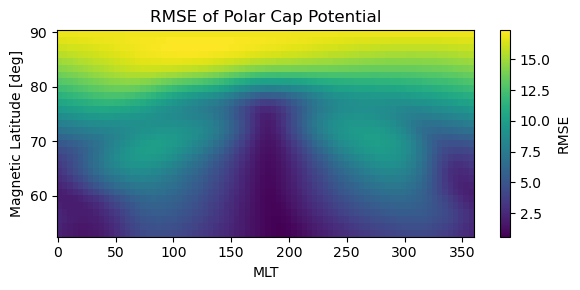

In [24]:
fig = plt.figure(figsize=(6,3))

#plot RMSE as radar plot
cbar = predicted_ds['RMSE'].mean('dt').plot()
plt.title('RMSE of Polar Cap Potential')
plt.ylabel('Magnetic Latitude [deg]')
#plt.xticks(np.arange(0, 25, 3))
plt.xlabel('MLT')

plt.tight_layout()

In [25]:
date = '2022-07-05T00:10:00.000000000'

# Extract true and predicted values
pot_true = predicted_ds['potential'].sel(dt=date).values
pot_pred = predicted_ds['predicted_pot'].sel(dt=date).values

pot_true


KeyError: "not all values found in index 'dt'. Try setting the `method` keyword argument (example: method='nearest')."

RMSE

In [ ]:
date = '2022-07-05T00:10:00.000000000'

# Extract true and predicted values
pot_true = predicted_ds['potential'].sel(dt=date).values
pot_pred = predicted_ds['predicted_pot'].sel(dt=date).values
rmse  = predicted_ds['RMSE'].sel(dt=date).values

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, rmse, levels=np.linspace(0, 8, 50), cmap='Reds', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('RMSE')
plt.colorbar(c_diff, ax=axs[2], label='RMSE [kV]', shrink=shrink, pad=0.1, ticks=np.arange(0,9,1), orientation='horizontal')


plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()

Difference

In [ ]:
date = '2022-07-05T00:10:00.000000000'

# Extract true and predicted values
pot_true = predicted_ds['potential'].sel(dt=date).values
pot_pred = predicted_ds['predicted_pot'].sel(dt=date).values
rmse  = predicted_ds['RMSE'].sel(dt=date).values

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, rmse, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
#axs[2].set_title('Difference \n(True - Predicted)')
#plt.colorbar(c_diff, ax=axs[2], label='Difference [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

#for RMAE
axs[2].set_title('RMSE')
plt.colorbar(c_diff, ax=axs[2], label='RMSE [kV]', shrink=shrink, pad=0.1, ticks=np.arange(0,31, 10), orientation='horizontal')


plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()